In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468246,72.528566,71.223244,71.476585,135480400
2020-01-03,71.763702,72.523731,71.539314,71.696144,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200
...,...,...,...,...,...
2025-12-05,278.779999,281.140015,278.049988,280.540009,47265800
2025-12-08,277.890015,279.670013,276.149994,278.130005,38211800


In [5]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [6]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.872803
2020-01-03,-1.887219
2020-01-06,-1.875518
2020-01-07,-1.882479
2020-01-08,-1.858782
...,...
2025-12-05,2.348538
2025-12-08,2.330328
2025-12-09,2.315801


In [7]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)


In [8]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [9]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [10]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
num_epochs=200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, Y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.735470712184906
25 0.00854303129017353
50 0.0056121754460036755
75 0.004775620996952057
100 0.004472218453884125
125 0.004226928111165762
150 0.003993066027760506
175 0.003760044928640127


In [23]:
model.eval()

y_train_pred = model(X_train)
y_test_pred = model(X_test)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
Y_train_inv = scaler.inverse_transform(Y_train.detach().cpu().numpy())

y_test_pred_inv = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
Y_test_inv = scaler.inverse_transform(Y_test.detach().cpu().numpy())


In [25]:
train_rmse = np.sqrt(mean_squared_error(Y_train_inv[:, 0], y_train_pred_inv[:, 0]))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv[:, 0], y_test_pred_inv[:, 0]))
r2score = r2_score(Y_test_inv, y_test_pred_inv)

In [22]:
train_rmse

2.9038327

In [16]:
test_rmse

8.720828

In [26]:
r2score

0.8595516681671143

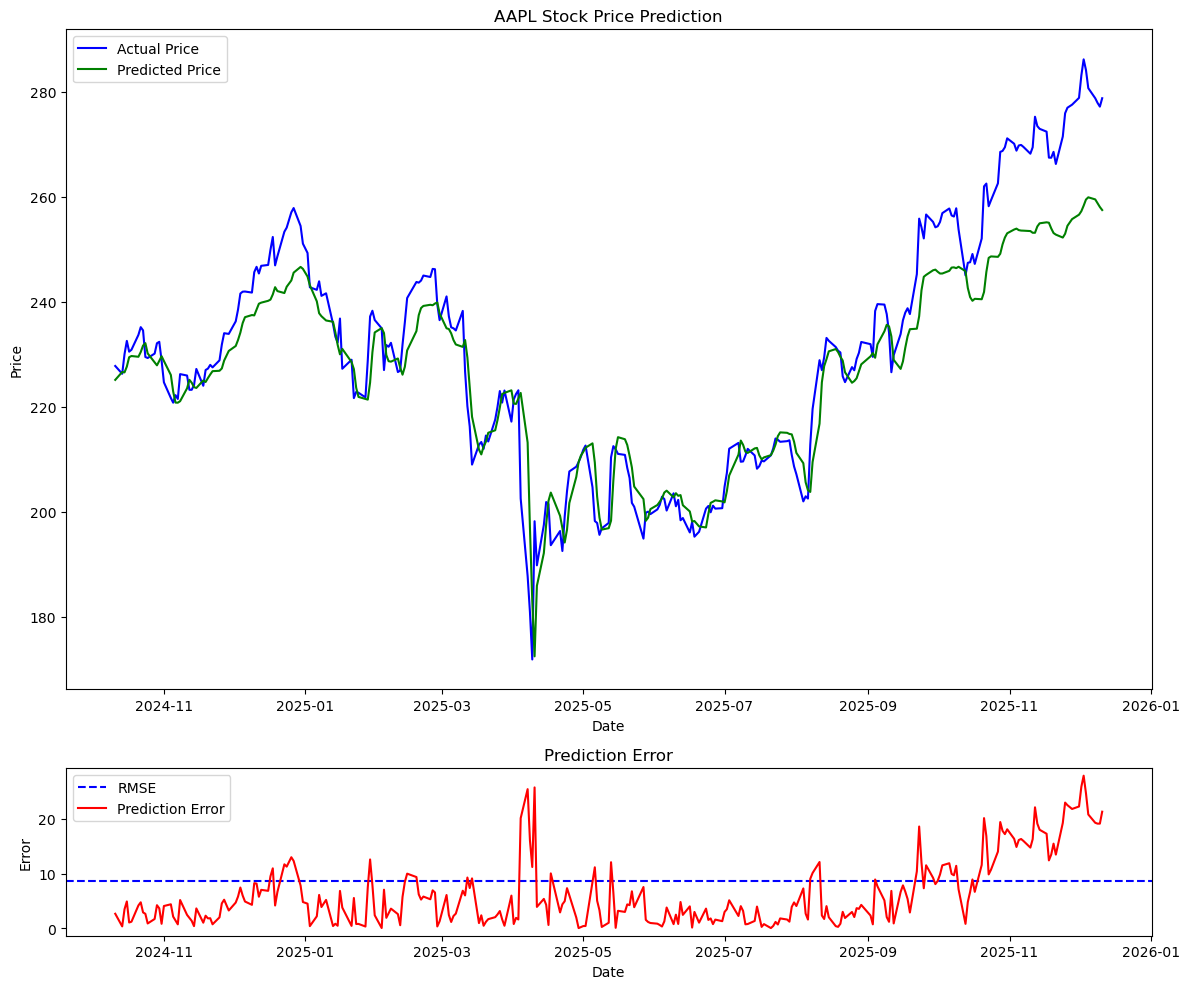

In [27]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(Y_test_inv):].index, Y_test_inv, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(Y_test_inv):].index, y_test_pred_inv, color='green', label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')
ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df.iloc[-len(Y_test_inv):].index, np.abs(Y_test_inv - y_test_pred_inv), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()
